In [6]:
from matplotlib import pyplot as plt
import numpy as np 
import pandas as pd 

data = pd.read_csv("./dataset/hmnist_28_28_RGB.csv")
data.head()
meta_df = pd.read_csv("./dataset/HAM10000_metadata.csv")
meta_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [7]:
meta_df.shape
data.shape

(10015, 2353)

In [8]:
yData = data['label']
XData = data.drop(columns = ['label'])
# EDA
distribution = meta_df['dx'].value_counts()
distribution
# classes = {4: ('nv', ' Nevus'),
#            6: ('mel', 'Melanoma'),
#            2 :('bkl', 'Seborrheic Keratosis'), 
#            1:('bcc' , ' Basal Cell Carcinoma '),
#            5: ('vasc', 'Vascular Lesion'),
#            0: ('akiec', 'Actinic Keratosis'),
#            3: ('df', 'Dermatofibroma')}

dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

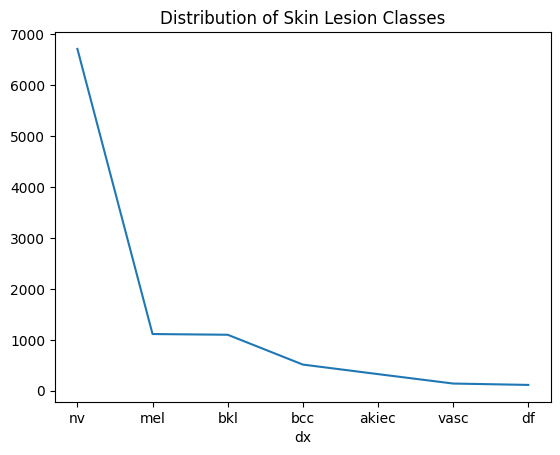

In [9]:
dist = data['label'].value_counts()
dist
distribution.plot()
plt.title('Distribution of Skin Lesion Classes')
plt.show()

In [10]:
# Fixing Data Imbalance
from imblearn.over_sampling import RandomOverSampler 
sampler = RandomOverSampler()
XData,yData  = sampler.fit_resample(XData,yData)
XData.shape, yData.shape
XData = np.array(XData).reshape((-1, 28, 28, 3))
XData = XData / 255
XData.shape

(46935, 28, 28, 3)

In [11]:
# Creating the train and validation set
from sklearn.model_selection import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(XData,yData, test_size=0.2)
Xtrain.shape, Xtest.shape

((37548, 28, 28, 3), (9387, 28, 28, 3))

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Dense, Dropout, Activation
from tensorflow.keras.layers import BatchNormalization, GlobalAveragePooling2D, SeparableConv2D
from tensorflow.keras.layers import Conv2DTranspose, ZeroPadding2D, SpatialDropout2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Input

input_shape = (28, 28, 3) 
num_classes = 7

# DermaNet

In [13]:
inputs = Input(shape=input_shape)
derma_net = Conv2D(32, (2, 2), padding='same')(inputs)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(32, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = Conv2D(64, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

derma_net = SeparableConv2D(128, (2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)
derma_net = SpatialDropout2D(0.2)(derma_net)
derma_net = MaxPooling2D(pool_size=(2, 2))(derma_net)

# Upsampling Layers
derma_net = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

derma_net = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = BatchNormalization()(derma_net)

# Global Average Pooling
derma_net = GlobalAveragePooling2D()(derma_net)

# Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

# More Dense Layers
derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

derma_net = Dense(128)(derma_net)
derma_net = Activation('swish')(derma_net)
derma_net = Dropout(0.5)(derma_net)

outputs = Dense(7)(derma_net)
outputs = Activation('softmax')(outputs)

DermaNet = Model(inputs=inputs, outputs=outputs)

DermaNet.compile(loss='sparse_categorical_crossentropy',optimizer='nadam',metrics=['accuracy'])

In [14]:
callback = tf.keras.callbacks.ModelCheckpoint(filepath='/kaggle/working/skin.keras',
                                              monitor='val_acc', mode='max',
                                              verbose=1)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
history = DermaNet.fit(Xtrain,
                    Ytrain,
                    epochs = 50,
                    validation_data = (Xtest, Ytest),
                    callbacks=[callback, early_stopping])

Epoch 1/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4959 - loss: 1.2916
Epoch 1: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 94s 68ms/step - accuracy: 0.4960 - loss: 1.2914 - val_accuracy: 0.7653 - val_loss: 0.6453
Epoch 2/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.7538 - loss: 0.6760
Epoch 2: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 99s 83ms/step - accuracy: 0.7539 - loss: 0.6760 - val_accuracy: 0.8178 - val_loss: 0.4849
Epoch 3/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8221 - loss: 0.4999
Epoch 3: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 220s 148ms/step - accuracy: 0.8221 - loss: 0.4998 - val_accuracy: 0.8286 - val_loss: 0.4704
Epoch 4/50
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.8500 - loss: 0.4110
Epoch 4: saving model to /kaggle/working/skin.keras
1174/1174 ━━━━━━━━━━━━━━━━━━━━ 224s 168ms/step - accuracy: 0.8500 - l

In [12]:
from tabulate import tabulate

loss_dermanet, accuracy_dermanet = DermaNet.evaluate(Xtest, Ytest)

table = [["\033[1mTest Accuracy\033[0m", "{:.2f}%".format(accuracy_dermanet * 100)],
         ["\033[1mTest Loss\033[0m", "{:.4f}".format(loss_dermanet)]]

print(tabulate(table, tablefmt="grid"))

294/294 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9755 - loss: 0.0711
+---------------+--------+
| Test Accuracy | 97.69% |
+---------------+--------+
| Test Loss     | 0.0715 |
+---------------+--------+


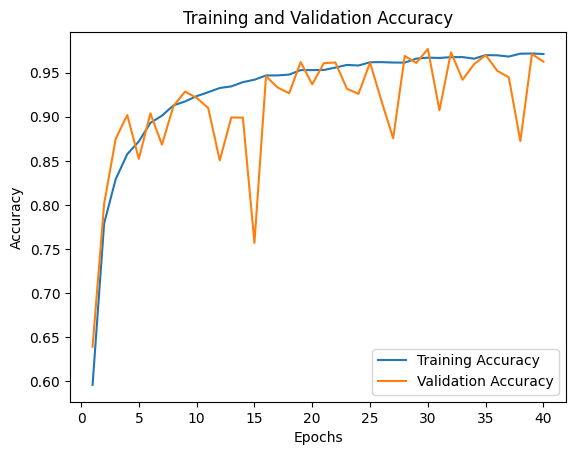

In [13]:
import matplotlib.pyplot as plt

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(range(1, len(train_acc) + 1), train_acc, label='Training Accuracy')
plt.plot(range(1, len(val_acc) + 1), val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

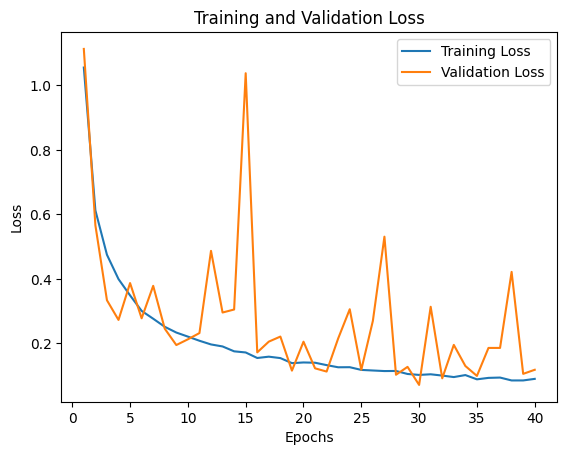

In [14]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()